In [1]:
import sklearn
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Perceptrons
### The Perceptron
- The Perceptron is one of the simplest ANN architectures, invented in 1957 by Frank Rosenblatt. 
- It is based on a slightly different artificial neuron called a **threshold logic unit (TLU)**, or sometimes a **linear threshold unit (LTU).** 
- The inputs and output are numbers (instead of binary on/off values), and each input connection is associated with a weight. 
- The TLU computes a weighted sum of its inputs, then applies a step function to that sum and outputs the result.
- The most common step function used in Perceptrons is the **Heaviside step function** (see Equation 10-1). 
    - Sometimes the **sign function** is used instead.


<img src="10-1.png">

- A single TLU can be used for simple linear binary classification. 
- It computes a linear combination of the inputs, and if the result exceeds a threshold, it outputs the positive class. 
- Otherwise it outputs the negative class (just like a Logistic Regression or linear SVM classifier). 
- You could, for example, use a single TLU to classify iris flowers based on petal length and width (also adding an extra bias feature x = 1). 
- Training a TLU in this case means finding the right values for $w_0$ , $w_1$ , and $w_2$(the training algorithm is discussed shortly).
***
- A Perceptron is simply composed of a single layer of TLUs, with each TLU connected to all the inputs. 
- When all the neurons in a layer are connected to every neuron in the previous layer (i.e., its input neurons), the layer is called a **fully connected layer**, or a **dense layer**. 
- The inputs of the Perceptron are fed to special passthrough neurons called input neurons: they output whatever input they are fed. 
- All the input neurons form the input layer. 
- Moreover, an extra bias feature is generally added (x = 1): it is typically represented using a special type of neuron called a **bias neuron**, which **outputs 1 all the time.**
- **The Perceptron is fed one training instance at a time, and for each instance it makes its predictions.**
    - **For every output neuron that produced a wrong prediction, it reinforces the connection weights from the inputs that would have contributed to the correct prediction.**
- **The decision boundary of each output neuron is linear, so Perceptrons are incapable of learning complex patterns (just like Logistic Regression classifiers).**

Scikit-Learn provides a **Perceptron class** that implements a single-TLU network.

In [2]:
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)] # petal length, petal width
y = (iris.target == 0).astype(np.int) # Iris setosa

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [3]:
y_pred

array([1])

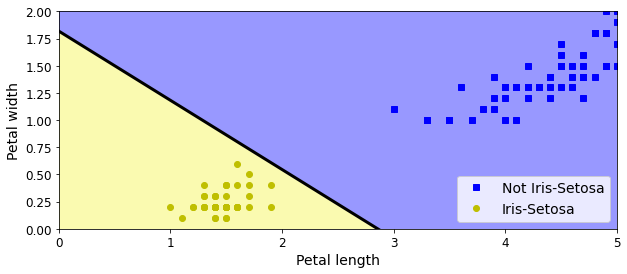

In [4]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

plt.show()

- You may have noticed that the Perceptron learning algorithm strongly resembles Stochastic Gradient Descent. 
    - In fact, Scikit-Learn’s Perceptron class is equivalent to using an **SGDClassifier** with the following hyperparameters: **loss="perceptron", learning_rate="constant", eta0=1 (the learning rate), and penalty=None** (no regularization).
- Note that contrary to Logistic Regression classifiers, Perceptrons do not output a class probability; rather, they make predictions based on a hard threshold. 
    - **This is one reason to prefer Logistic Regression over Perceptrons.**
- In their 1969 monograph Perceptrons, Marvin Minsky and Seymour Papert highlighted a number of serious weaknesses of Perceptrons—in particular, the fact that they are incapable of solving some trivial problems (e.g., the Exclusive OR (XOR) classification problem; see the left side of Figure 10- 6). 
    - This is true of any other linear classification model (such as Logistic Regression classifiers), but researchers had expected much more from Perceptrons, and some were so disappointed that they dropped neural networks altogether in favor of higher-level problems such as logic, problem solving, and search.
- It turns out that some of the limitations of Perceptrons can be eliminated **by stacking multiple Perceptrons.** 
- The resulting ANN is called a **Multilayer Perceptron (MLP)**. 
    - An MLP can solve the XOR problem, as you can verify by computing the output of the MLP represented on the right side of Figure 10-6: with inputs (0, 0) or (1, 1), the network outputs 0, and with inputs (0, 1) or (1, 0) it outputs 1. 
    - All connections have a weight equal to 1, except the four connections where the weight is shown.

<img src="10-6.png">

## The Multilayer Perceptron and Backpropagation
- An MLP is composed of **one (passthrough) input layer, one or more layers of TLUs, called hidden layers, and one final layer of TLUs called the output layer** (see Figure 10-7). 
- The layers close to the input layer are usually called the lower layers, and the ones close to the outputs are usually called the upper layers. 
- Every layer **except the output layer** includes a bias neuron and is fully connected to the next layer.
<img src="10-7.png">

### NOTE
The signal flows only in one direction (from the inputs to the outputs), so this architecture is an example of a **feedforward neural network (FNN).**
***
- When an ANN contains a deep stack of hidden layers(an ANN with more than two hidden layers), it is called a **deep neural network (DNN).** 
- The field of Deep Learning studies DNNs, and more generally models containing deep stacks of computations. Even so, many people talk about Deep Learning whenever neural networks are involved (even shallow ones).

## Backpropagation
- For many years researchers struggled to find a way to train MLPs, without success. 
- But in 1986, David Rumelhart, Geoffrey Hinton, and Ronald Williams published a groundbreaking paper that introduced the **backpropagation training algorithm**, which is still used today. 
- In short, it is **Gradient Descent using an efficient technique for computing the gradients automatically: in just two passes through the network (one forward, one backward),** the **backpropagation algorithm** is able to compute the gradient of the network’s error with regard to every single model parameter. 
    - **In other words, it can find out how each connection weight and each bias term should be tweaked in order to reduce the error.**
    - Once it has these gradients, it just performs a regular Gradient Descent step, and **the whole process is repeated until the network converges to the solution.**

***
### NOTE
- Automatically computing gradients is called **automatic differentiation, or autodiff.** 
- There are various autodiff techniques, with different pros and cons. 
- **The one used by backpropagation is called reverse-mode autodiff.** 
    - It is fast and precise, and is well suited when the function to differentiate has many variables (e.g., connection weights) and few outputs (e.g., one loss).
***    
#### Let’s run through this algorithm(backpropagation) in a bit more detail:
- It handles one mini-batch at a time (for example, containing 32 instances each), and it goes through the full training set multiple times. 
    - Each pass is called an **epoch.**
- Each mini-batch is passed to the network’s input layer, which sends it to the first hidden layer. 
    - The algorithm then computes the output of all the neurons in this layer (for every instance in the mini-batch). 
    - The result is passed on to the next layer, its output is computed and passed to the next layer, and so on until we get the output of the last layer, the output layer. 
    - **This is the forward pass: it is exactly like making predictions, except all intermediate results are preserved since they are needed for the backward pass.**
- The algorithm then measures how much of these error contributions came from each connection in the layer below, again using the chain rule, working backward until the algorithm reaches the input layer. 
    - As explained earlier, this reverse pass efficiently measures the error gradient across all the connection weights in the network by propagating the error gradient backward through the network (hence the name of the algorithm).
- Finally, the algorithm performs a Gradient Descent step to tweak all the connection weights in the network, using the error gradients it just computed.

#### This algorithm is so important that it’s worth summarizing it again:
- **for each training instance, the backpropagation algorithm first makes a prediction (forward pass) and measures the error,** 
- **then goes through each layer in reverse to measure the error contribution from each connection (reverse pass),** 
- **and finally tweaks the connection weights to reduce the error (Gradient Descent step).**

### WARNING
#### It is important to initialize all the hidden layers’ connection weights randomly, or else training will fail.
- For example, if you initialize all weights and biases to zero, then all neurons in a given layer will be perfectly identical, and thus backpropagation will affect them in exactly the same way, so they will remain identical.
- In other words, despite having hundreds of neurons per layer, your model will act as if it had only one neuron per layer: it won’t be too smart. 
    - If instead you randomly initialize the weights, you break the symmetry and allow backpropagation to train a diverse team of neurons.
***

## Activation functions
- In order for this algorithm to work properly, its authors made a key change to the MLP’s architecture: they replaced the step function with the **logistic (sigmoid) function**, σ(z) = 1 / (1 + exp(–z)). 
    - This was essential because the **step function contains only flat segments**, so there is no gradient to work with (Gradient Descent cannot move on a flat surface), **while the logistic(sigmoid) function has a well-defined nonzero derivative everywhere, allowing Gradient Descent to make some progress at every step.** 
- In fact, the backpropagation algorithm works well with many other activation functions, not just the logistic function.
    - Here are two other popular choices:


#### The hyperbolic tangent function: tanh(z) = 2σ(2z) – 1
- Just like the logistic(sigmoid) function, this activation function is **S-shaped, continuous, and differentiable, but its output value ranges from –1 to 1 (instead of 0 to 1 in the case of the logistic function).** 
- That range tends to make each layer’s output more or less centered around 0 at the beginning of training, which often helps speed up convergence.

#### The Rectified Linear Unit function: ReLU(z) = max(0, z)
- The ReLU function is **continuous but unfortunately not differentiable at z = 0 **(the slope changes abruptly, which can make Gradient Descent bounce around), and its derivative is 0 for z < 0. 
- **In practice, however, it works very well and has the advantage of being fast to compute, so it has become the default.**
- Most importantly, the fact that it **does not have a maximum output value** helps reduce some issues during Gradient Descent.

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

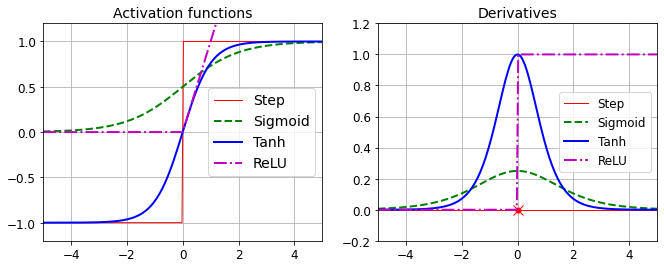

In [6]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=12)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

- These popular activation functions and their derivatives are represented above. But wait! Why do we need activation functions in the first place? 
    - Well, if you chain several linear transformations, all you get is a linear transformation. 
    - For example, if f(x) = 2x + 3 and g(x) = 5x – 1, then chaining these two linear functions gives you another linear function: f(g(x)) = 2(5x – 1) + 3 = 10x + 1. So if you don’t have some nonlinearity between layers, then even a deep stack of layers is equivalent to a single layer, and you can’t solve very complex problems with that. 
- Conversely, a large enough DNN with nonlinear activations can theoretically approximate any continuous function.
OK! You know where neural nets came from, what their architecture is, and how to compute their outputs. You’ve also learned about the backpropagation algorithm. But what exactly can you do with them?
## Regression MLPs
- First, MLPs can be used for regression tasks. 
- If you want to predict a single value (e.g., the price of a house, given many of its features), then you just need a single output neuron: its output is the predicted value. 
- For multivariate regression (i.e., to predict multiple values at once), you need one output neuron per output dimension. 
    - For example, to locate the center of an object in an image, you need to predict 2D coordinates, so you need two output neurons. 
    - If you also want to place a bounding box around the object, then you need two more numbers: the width and the height of the object. So, you end up with four output neurons.
- In general, when building an MLP for regression, you do not want to use any activation function for the output neurons, so they are free to output any range of values. 
    - **If you want to guarantee that the output will always be positive**, then you can use the **ReLU** activation function in the output layer.
    - Alternatively, you can use the **softplus** activation function, which is a smooth variant of ReLU: softplus(z) = log(1 + exp(z)). 
        - **It is close to 0 when z is negative, and close to z when z is positive.** 
    - Finally, **if you want to guarantee that the predictions will fall within a given range of values**, then you can use the **logistic(sigmoid) function or the hyperbolic tangent**, 
        - **and then scale the labels to the appropriate range: 0 to 1 for the logistic(sigmoid) function** 
        - **and –1 to 1 for the hyperbolic tangent.**
- **The loss function to use during training** is typically the **mean squared error**, 
    - **but if you have a lot of outliers in the training set**, you may prefer to use the **mean absolute error** instead.
    - Alternatively, you can use the **Huber loss**, which is a combination of both.
### TIP
- The Huber loss is quadratic when the error is smaller than a threshold δ (typically 1) 
    - but linear when the error is larger than δ. 
- The linear part makes it less sensitive to outliers than the mean squared error, 
    - and the quadratic part allows it to converge faster and be more precise than the mean absolute error.

#### Table 10-1 summarizes the typical architecture of a regression MLP.
<img src="t1.png">

## Classification MLPs
- MLPs can also be used for classification tasks. 
- **For a binary classification problem, you just need a single output neuron using the logistic(sigmoid) activation function: the output will be a number between 0 and 1, which you can interpret as the estimated probability of the positive class.**
    - The estimated probability of the negative class is equal to one minus that number.
- MLPs can also easily handle **multilabel binary classification tasks.**
- For example, you could have an email classification system that predicts whether each incoming email is ham or spam, and simultaneously predicts whether it is an urgent or nonurgent email. 
    - In this case, you would need two output neurons, both using the logistic(sigmoid) activation function: the first would output the probability that the email is spam, and the second would output the probability that it is urgent. 
    - More generally, you would dedicate one output neuron for each positive class.
    - Note that the output probabilities do not necessarily add up to 1. 
    - This lets the model output any combination of labels: you can have nonurgent ham, urgent ham, nonurgent spam, and perhaps even urgent spam (although that would probably be an error).
- If each instance can belong only to a single class, out of three or more possible classes (e.g., classes 0 through 9 for digit image classification), **then you need to have one output neuron per class**, and you should use the **softmax activation function** for the whole **output layer**(see Figure 10-9).
- The softmax function will ensure that all the estimated probabilities are between 0 and 1 and that they add up to 1 (which is required if the classes are exclusive). 
    - This is called **multiclass classification.**

<img src="10-9.png">

- Regarding the **loss function**, since we are predicting probability distributions, the **cross-entropy loss (also called the log loss)** is generally a good choice.
#### Table 10-2 summarizes the typical architecture of a classification MLP.

<img src="t2.png">

## Implementing MLPs with Keras

In [7]:
import tensorflow as tf
from tensorflow import keras

In [8]:
tf.__version__

'2.4.1'

In [9]:
keras.__version__

'2.4.0'

## Building an Image Classifier
- Let's start by loading the fashion MNIST dataset(70,000 grayscale images of 28 × 28 pixels each, with 10 classes). 
- Keras has a number of functions to load popular datasets in keras.datasets. 
- The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [10]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

- When loading MNIST or Fashion MNIST using Keras rather than Scikit- Learn, one important difference is that **every image is represented as a 28 × 28 array rather than a 1D array of size 784.** 
- Moreover, the pixel intensities are represented as integers (from 0 to 255) rather than floats (from 0.0 to 255.0). 

Let’s take a look at the shape and data type of the training set:

In [11]:
X_train_full.shape

(60000, 28, 28)

In [12]:
X_train_full.dtype

dtype('uint8')

- Note that the dataset is already split into a training set and a test set, but there is no validation set, so we’ll create one now. 
- Additionally, since we are going to train the neural network using **Gradient Descent, we must scale the input features.** 
- For simplicity, we’ll scale the pixel intensities down to the 0–1 range by dividing them by 255.0 (this also converts them to floats):

In [13]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

#### You can plot an image using Matplotlib's imshow() function, with a 'binary' color map:

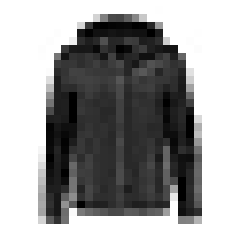

In [14]:
plt.imshow(X_train[0], cmap="binary")
plt.axis("off")
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [15]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

- With MNIST, when the label is equal to 5, it means that the image represents the handwritten digit 5. Easy. 
- For Fashion MNIST, however, **we need the list of class names to know what we are dealing with:**

In [16]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [17]:
class_names[y_train[0]]

'Coat'

#### The validation set contains 5,000 images, and the test set contains 10,000 images:

In [18]:
X_valid.shape

(5000, 28, 28)

In [19]:
X_test.shape

(10000, 28, 28)

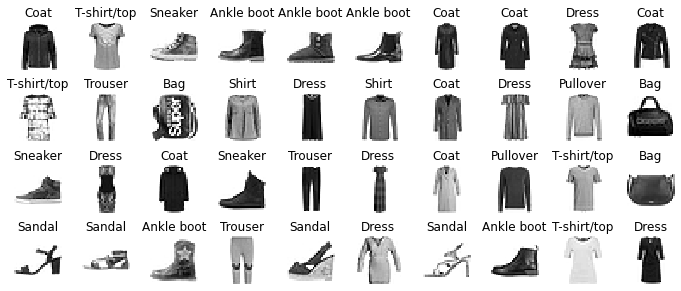

In [20]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis("off")
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

### Creating the model using the Sequential API
#### A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
Now let’s build the neural network! Here is a classification MLP with two hidden layers:

In [21]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) #Flatten layer
model.add(keras.layers.Dense(300, activation="relu")) #Hidden layer
model.add(keras.layers.Dense(100, activation="relu")) #Hidden layer
model.add(keras.layers.Dense(10, activation="softmax")) #Output layer

Let’s go through this code line by line:
- The first line creates a Sequential model. 
    - This is the simplest kind of Keras model for neural networks that are just composed of a single stack of layers connected sequentially. 
    - This is called the Sequential API.
- Next, we build the first layer and add it to the model. 
    - It is a **Flatten layer** whose role is to convert each input image into a 1D array: if it receives input data X, it computes X.reshape(-1, 1).
    - This layer does not have any parameters; it is just there to do some simple preprocessing. 
    - Since it is the first layer in the model, you should specify the input_shape, which doesn’t include the batch size, only the shape of the instances. 
        - Alternatively, you could add a keras.layers.InputLayer as the first layer, setting input_shape=[28,28].
- Next we add a **Dense hidden layer** with 300 neurons. 
    - It will use the **ReLU activation function**. 
    - Each Dense layer manages its own weight matrix, containing all the connection weights between the neurons and their inputs. 
    - It also manages a vector of bias terms (one per neuron).
- Then we add a **second Dense hidden layer** with 100 neurons, also using the **ReLU activation function**.
- **Finally, we add a Dense output layer with 10 neurons (one per class), using the softmax activation function (because the classes are exclusive).**

### TIP
Specifying **activation="relu"** is equivalent to specifying **activation=keras.activations.relu**.
***

#### Instead of adding the layers one by one as we just did, you can pass a list of layers when creating the Sequential model:

In [22]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [23]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), 
    keras.layers.Dense(300, activation="relu"), 
    keras.layers.Dense(100, activation="relu"), 
    keras.layers.Dense(10, activation="softmax")
])

Note that Dense layers often have a lot of parameters. 
- For example, the first hidden layer has 784 × 300 connection weights, plus 300 bias terms, which adds up to 235,500 parameters! 
    - This gives the model quite a lot of flexibility to fit the training data, but it also means that the model runs the risk of overfitting, especially when you do not have a lot of training data.

- The model’s summary() method displays all the model’s layers, including each layer’s name (which is automatically generated unless you set it when creating the layer), its output shape (**None means the batch size can be anything**), and its number of parameters. 
- The summary ends with the total number of parameters, including trainable and non-trainable parameters.
    - Here we only have trainable parameters.

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


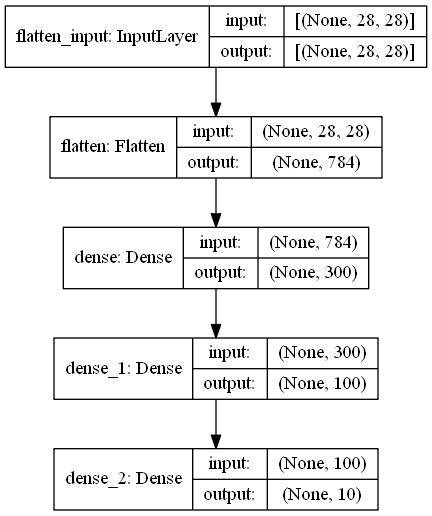

In [25]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

You can easily get a model’s list of layers, to fetch a layer by its index, or you can fetch it by name:

In [26]:
model.layers

In [27]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [28]:
model.get_layer(hidden1.name) is hidden1

True

- All the parameters of a layer can be accessed using its **get_weights()** and **set_weights()** methods. 
    - For a Dense layer, this includes both the connection weights and the bias terms:

In [29]:
weights, biases = hidden1.get_weights()

In [30]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [31]:
weights.shape

(784, 300)

In [32]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [33]:
biases.shape

(300,)

- Notice that the **Dense layer initialized the connection weights randomly** (which is needed to break symmetry, as we discussed earlier), and the **biases were initialized to zeros**, which is fine. 
- If you ever want to use a different initialization method, you can set **kernel_initializer** (kernel is another name for the matrix of connection weights) or **bias_initializer** when creating the layer.
### NOTE
- The shape of the weight matrix depends on the number of inputs. 
    - This is why it is recommended to specify the input_shape when creating the first layer in a Sequential model. 
    - However, if you do not specify the input shape, it’s OK: Keras will simply wait until it knows the input shape before it actually builds the model. 
    - This will happen either when you feed it actual data (e.g., during training), or when you call its build() method. 
    - Until the model is really built, the layers will not have any weights, and you will not be able to do certain things (such as print the model summary or save the model). 
    - So, if you know the input shape when creating the model, it is best to specify it.
***

### Compiling the model
- After a model is created, you must call its **compile() method to specify the loss function and the optimizer to use.** 
- Optionally, you can specify a list of extra metrics to compute during training and evaluation:

In [34]:
model.compile(loss="sparse_categorical_crossentropy", 
             optimizer="sgd", 
             metrics="accuracy")

This is equivalent to:

model.compile(loss=keras.losses.sparse_categorical_crossentropy,

              optimizer=keras.optimizers.SGD(),
              
              metrics=[keras.metrics.sparse_categorical_accuracy])
              

This code requires some explanation. 
- First, we use the **"sparse_categorical_crossentropy" loss because we have sparse labels(i.e., for each instance, there is just a target class index, from 0 to 9 in this case), and the classes are exclusive. **
    - If instead we had **one target probability per class for each instance** (such as one-hot vectors, e.g. [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.] to represent class 3), then we would need to use the **"categorical_crossentropy" loss** instead. 
    - If we were doing **binary classification (with one or more binary labels)**, then we would use the **"sigmoid" (i.e., logistic) activation function in the output layer instead of the "softmax" activation function**, and we would use the **"binary_crossentropy"** loss.
- Regarding the **optimizer, "sgd" means that we will train the model using simple Stochastic Gradient Descent.** 
    - In other words, Keras will perform the backpropagation algorithm described earlier (i.e., reverse-mode autodiff plus Gradient Descent).

### TIP
If you want to **convert sparse labels (i.e., class indices) to one-hot vector labels**, use the **keras.utils.to_categorical()** function. 

**To go the other way round, use the np.argmax() function with axis=1.**
### NOTE
- **When using the SGD optimizer, it is important to tune the learning rate.** 
- So, you will generally want to use **optimizer=keras.optimizers.SGD(lr=???)** to set the learning rate, rather than optimizer="sgd", which defaults to lr=0.01.
***

Finally, since this is a classifier, it’s useful to measure its "accuracy" during training and evaluation.
## Training and evaluating the model
Now the model is ready to be trained. For this we simply need to call its fit() method:

In [35]:
history = model.fit(X_train, y_train, epochs=30, 
                   validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 13s 5ms/step - loss: 1.0187 - accuracy: 0.6805 - val_loss: 0.5213 - val_accuracy: 0.8226
Epoch 2/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5027 - accuracy: 0.8262 - val_loss: 0.4353 - val_accuracy: 0.8526
Epoch 3/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4483 - accuracy: 0.8426 - val_loss: 0.5329 - val_accuracy: 0.7986
Epoch 4/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4207 - accuracy: 0.8528 - val_loss: 0.3917 - val_accuracy: 0.8658
Epoch 5/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4060 - accuracy: 0.8581 - val_loss: 0.3744 - val_accuracy: 0.8700
Epoch 6/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3754 - accuracy: 0.8673 - val_loss: 0.3712 - val_accuracy: 0.8734
Epoch 7/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3653 - accuracy: 0.8714 - val_loss: 0.3617 - val_accuracy

### TIP
- Instead of passing a validation set using the validation_data argument, you could set validation_split to the ratio of the training set that you want Keras to use for validation. 
    - For example, validation_split=0.1 tells Keras to use the last 10% of the data (before shuffling) for validation.
***
- If the training set was very skewed, with some classes being overrepresented and others underrepresented, it would be useful to set the **class_weight argument when calling the fit()** method, which would give a larger weight to underrepresented classes and a lower weight to overrepresented classes. 
- These weights would be used by Keras when computing the loss. 
- If you need per-instance weights, set the **sample_weight** argument (it supersedes class_weight). 
    - Per-instance weights could be useful if some instances were labeled by experts while others were labeled using a crowdsourcing platform: you might want to give more weight to the former. 
    - You can also provide sample weights (but not class weights) for the validation set by adding them as a third item in the validation_data tuple.
- The fit() method returns a History object containing the training parameters (history.params), the list of epochs it went through (history.epoch), and most importantly a dictionary (history.history) containing the loss and extra metrics it measured at the end of each epoch on the training set and on the validation set (if any).

In [36]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [37]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

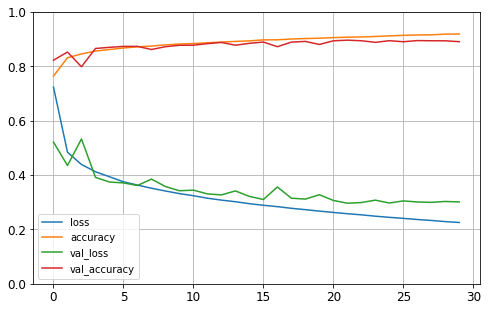

In [39]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]

plt.show()

#### Learning curves: the mean training loss and accuracy measured over each epoch, and the mean validation loss and accuracy measured at the end of each epoch

- The validation error is computed at the end of each epoch, while the training error is computed using a running mean during each epoch. 
    - So the training curve should be shifted by half an epoch to the left. 
    - If you do that, you will see that the training and validation curves overlap almost perfectly at the beginning of training.

### TIP
When plotting the training curve, it should be shifted by half an epoch to the left.

- The training set performance ends up beating the validation performance, as is generally the case when you train for long enough. 
- You can tell that the model has not quite converged yet, as the validation loss is still going down, so you should probably continue training. 
- It’s as simple as calling the fit() method again, since Keras just continues training where it left off (you should be able to reach close to 89% validation accuracy). 

In [40]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3357 - accuracy: 0.8828


[0.3356936573982239, 0.8827999830245972]

### Using the model to make predictions
Next, we can use the model’s predict() method to make predictions on new instances. Since we don’t have actual new instances, we will just use the first three instances of the test set:

In [41]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.96],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

- As you can see, for each instance the model estimates one probability per class, from class 0 to class 9. 
    - For example, for the first image it estimates that the probability of class 9 (ankle boot) is 96%, the probability of class 5 (sandal) is 3%, the probability of class 7 (sneaker) is 1%, and the probabilities of the other classes are negligible. 
    - In other words, it “believes” the first image is footwear, most likely ankle boots but possibly sandals or sneakers. 
    - If you only care about the class with the highest estimated probability (even if that probability is quite low), then you can use the predict_classes() method instead:

**Warning:** model.predict_classes(X_new) is deprecated. It is replaced with np.argmax(model.predict(X_new), axis=-1).

In [42]:
#y_pred = model.predict_classes(X_new) # deprecated
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

array([9, 2, 1], dtype=int64)

In [43]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [44]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Here, the classifier actually classified all three images correctly

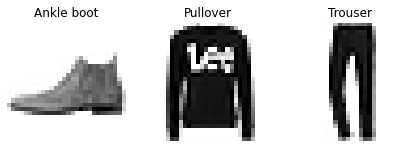

In [45]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis("off")
    plt.title(class_names[y_test[index]], fontsize=12)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

## Building a Regression MLP Using the Sequential API
#### A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
Let's load, split and scale the California housing dataset 

In [46]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [47]:
np.random.seed(42)
tf.random.set_seed(42)

- Using the Sequential API to build, train, evaluate, and use a regression MLP to make predictions is quite similar to what we did for classification.
- The main differences are the fact that the **output layer has a single neuron (since we only want to predict a single value) and uses no activation function**, and the **loss function is the mean squared error.** 
- Since the dataset is quite noisy, we just use a single hidden layer with fewer neurons than before, to avoid overfitting:

In [48]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]), 
    keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 2s 3ms/step - loss: 2.2656 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7413 - val_loss: 0.6531
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6604 - val_loss: 0.6099
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6245 - val_loss: 0.5658
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5770 - val_loss: 0.5355
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5609 - val_loss: 0.5173
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5500 - val_loss: 0.5081
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5200 - val_loss: 0.4799
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5051 - val_loss: 0.4690
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4910 - val_loss: 0.4656

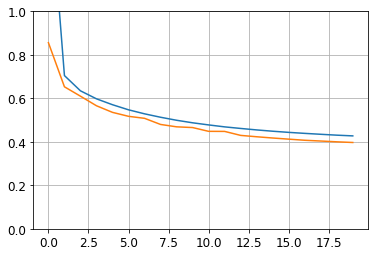

In [49]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [50]:
y_pred

array([[0.3885665],
       [1.6792021],
       [3.1022792]], dtype=float32)

- As you can see, the Sequential API is quite easy to use. 
- However, although Sequential models are extremely common, it is sometimes useful to build neural networks with more complex topologies, or with multiple inputs or outputs. 
    - For this purpose, Keras offers the Functional API.

## Building Complex Models Using the Functional API
#### Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network connects all or part of the inputs directly to the output layer.
<img src="10-14.png">

In [51]:
np.random.seed(42)
tf.random.set_seed(42)

In [52]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

Let’s go through each line of this code:
- First, we need to create an Input object. 
    - This is a specification of the kind of input the model will get, including its shape and dtype. 
- Next, we create a Dense layer with 30 neurons, using the ReLU activation function. 
    - As soon as it is created, notice that we call it like a function, passing it the input. 
    - This is why this is called the Functional API. 
    - Note that we are just telling Keras how it should connect the layers together; no actual data is being processed yet.
- We then create a second hidden layer, and again we use it as a function. 
    - Note that we pass it the output of the first hidden layer.
- Next, we create a Concatenate layer, and once again we immediately use it like a function, to concatenate the input and the output of the second hidden layer. 
- Then we create the output layer, with a single neuron and no activation function, and we call it like a function, passing it the result of the concatenation.
- Lastly, we create a Keras Model, specifying which inputs and outputs to use.

In [53]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_6[0][0]                

In [54]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 2s 3ms/step - loss: 1.9731 - val_loss: 3.3940
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7638 - val_loss: 0.9360
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6045 - val_loss: 0.5649
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5862 - val_loss: 0.5712
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5452 - val_loss: 0.5045
Epoch 6/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5243 - val_loss: 0.4831
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5185 - val_loss: 0.4639
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4947 - val_loss: 0.4638
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4782 - val_loss: 0.4421
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4708 - val_loss: 0.4313

What if you want to send a subset of the features through the wide path and a different subset (possibly overlapping) through the deep path? 
- In this case, one solution is to use multiple inputs. 
    - For example, suppose we want to send five features through the wide path (features 0 to 4), 
    - and six features through the deep path (features 2 to 7):
    
Note that 3 features will go through both (features 2, 3 and 4).

In [55]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

<img src="10-15.png">

- Now we can compile the model as usual, but **when we call the fit() method, instead of passing a single input matrix X_train, we must pass a pair of matrices (X_train_A, X_train_B): one per input.** 
- **The same is true for X_valid, and also for X_test and X_new when you call evaluate() or predict():**

In [56]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 1s 3ms/step - loss: 2.9131 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.8125 - val_loss: 0.6710
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6876 - val_loss: 0.6169
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6241 - val_loss: 0.5710
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5770 - val_loss: 0.5420
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5416 - val_loss: 0.5176
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5449 - val_loss: 0.5065
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5136 - val_loss: 0.4790
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4917 - val_loss: 0.4564
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4781 - val_loss: 0.4451

There are many use cases in which you may want to have multiple outputs:
- The task may demand it. 
    - For instance, you may want to locate and classify the main object in a picture. 
    - This is both a regression task (finding the coordinates of the object’s center, as well as its width and height) and a classification task.
- Similarly, you may have multiple independent tasks based on the same data. 
    - Sure, you could train one neural network per task, but in many cases you will get better results on all tasks by training a single neural network with one output per task. 
    - This is because the neural network can learn features in the data that are useful across tasks. 
    - For example, you could perform multitask classification on pictures of faces, using one output to classify the person’s facial expression (smiling, surprised, etc.) and another output to identify whether they are wearing glasses or not.
- Another use case is as a regularization technique (i.e., a training constraint whose objective is to reduce overfitting and thus improve the model’s ability to generalize). 
    - For example, you may want to add some auxiliary outputs in a neural network architecture (see Figure 10-16) to ensure that the underlying part of the network learns something useful on its own, without relying on the rest of the network.

<img src="10-16.png">

#### Adding an auxiliary output for regularization:

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

In [58]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)

model = keras.models.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

- Each output will need its own loss function. Therefore, when we compile the model, we should pass a list of losses (if we pass a single loss, Keras will assume that the same loss must be used for all outputs). 
    - By default, Keras will compute all these losses and simply add them up to get the final loss used for training.
- We care much more about the main output than about the auxiliary output (as it is just used for regularization), so we want to give the main output’s loss a much greater weight. 
    - Fortunately, it is possible to set all the loss weights when compiling the model:

In [59]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

In [60]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20, 
                   validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 2s 3ms/step - loss: 3.4633 - main_output_loss: 3.3289 - aux_output_loss: 4.6732 - val_loss: 1.6233 - val_main_output_loss: 0.8468 - val_aux_output_loss: 8.6117
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.9807 - main_output_loss: 0.7503 - aux_output_loss: 3.0537 - val_loss: 1.5163 - val_main_output_loss: 0.6836 - val_aux_output_loss: 9.0109
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7742 - main_output_loss: 0.6290 - aux_output_loss: 2.0810 - val_loss: 1.4639 - val_main_output_loss: 0.6229 - val_aux_output_loss: 9.0326
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6952 - main_output_loss: 0.5897 - aux_output_loss: 1.6449 - val_loss: 1.3388 - val_main_output_loss: 0.5481 - val_aux_output_loss: 8.4552
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6469 - main_output_loss: 0.5508 - aux_output_loss: 1.5118 - val_loss

- Now when we train the model, we need to provide labels for each output. 
- In this example, the main output and the auxiliary output should try to predict the same thing, so they should use the same labels. 
    - So instead of passing y_train, we need to pass (y_train, y_train) (and the same goes for y_valid and y_test):

In [61]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

162/162 [==============================] - 0s 2ms/step - loss: 0.4668 - main_output_loss: 0.4178 - aux_output_loss: 0.9082


## Using the Subclassing API to Build Dynamic Models
- **Both the Sequential API and the Functional API are declarative:** you start by declaring which layers you want to use and how they should be connected, and only then can you start feeding the model some data for training or inference. 
    - This has many advantages: the model can easily be saved, cloned, and shared; its structure can be displayed and analyzed; the framework can infer shapes and check types, so errors can be caught early (i.e., before any data ever goes through the model). 
    - It’s also fairly easy to debug, since the whole model is a static graph of layers. 
- But the flip side is just that: it’s static. Some models involve loops, varying shapes, conditional branching, and other dynamic behaviors. 
    - **For such cases, or simply if you prefer a more imperative programming style, the Subclassing API is for you.**
- Simply subclass the Model class, create the layers you need in the constructor, and use them to perform the computations you want in the call() method. 
    - **For example, creating an instance of the following WideAndDeepModel class gives us an equivalent model to the one we just built with the Functional API.** 
    - You can then compile it, evaluate it, and use it to make predictions, exactly like we just did:

In [62]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
    
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output
    
model = WideAndDeepModel(30, activation="relu")

In [63]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10, 
                   validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))

total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 [==============================] - 2s 3ms/step - loss: 3.3855 - output_1_loss: 3.3304 - output_2_loss: 3.8821 - val_loss: 2.1435 - val_output_1_loss: 1.1581 - val_output_2_loss: 11.0117
Epoch 2/10
363/363 [==============================] - 1s 3ms/step - loss: 1.0790 - output_1_loss: 0.9329 - output_2_loss: 2.3942 - val_loss: 1.7567 - val_output_1_loss: 0.8205 - val_output_2_loss: 10.1825
Epoch 3/10
363/363 [==============================] - 1s 3ms/step - loss: 0.8644 - output_1_loss: 0.7583 - output_2_loss: 1.8194 - val_loss: 1.5664 - val_output_1_loss: 0.7913 - val_output_2_loss: 8.5419
Epoch 4/10
363/363 [==============================] - 1s 3ms/step - loss: 0.7850 - output_1_loss: 0.6979 - output_2_loss: 1.5689 - val_loss: 1.3088 - val_output_1_loss: 0.6549 - val_output_2_loss: 7.1933
Epoch 5/10
363/363 [==============================] - 1s 3ms/step - loss: 0.7294 - output_1_loss: 0.6499 - output_2_loss: 1.4452 - val_loss: 1.1357 - val_output_1_loss: 0.5964 - val_

In [64]:
model = WideAndDeepModel(30, activation="relu")

- This example looks very much like the Functional API, except we do not need to create the inputs; we just use the input argument to the call() method, and we separate the creation of the layers in the constructor from their usage in the call() method. 
    - The big difference is that you can do pretty much anything you want in the call() method: for loops, if statements, low-level TensorFlow operations—your imagination is the limit.
- This extra flexibility does come at a cost: your **model’s architecture is hidden within the call() method, so Keras cannot easily inspect it; it cannot save or clone it; and when you call the summary() method,** you only get a list of layers, without any information on how they are connected to each other. 
    - Moreover, Keras cannot check types and shapes ahead of time, and it is easier to make mistakes. 
    - **So unless you really need that extra flexibility, you should probably stick to the Sequential API or the Functional API.**
### TIP
#### Keras models can be used just like regular layers, so you can easily combine them to build complex architectures.
***

## Saving and Restoring a Model
When using the Sequential API or the Functional API, saving a trained Keras model is as simple as it gets:

In [65]:
np.random.seed(42)
tf.random.set_seed(42)

In [66]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]), 
    keras.layers.Dense(30, activation="relu"), 
    keras.layers.Dense(1)
])

In [67]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 3ms/step - loss: 3.3697 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6964 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6167 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5846 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5321 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5083 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5044 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4813 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4627 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 1ms/step - loss: 0.4382


In [68]:
model.save("my_keras_model.h5")

- Keras will use the HDF5 format to save both the model’s architecture (including every layer’s hyperparameters) and the values of all the model parameters for every layer (e.g., connection weights and biases). 
    - It also saves the optimizer (including its hyperparameters and any state it may have).
- You will typically have a script that trains a model and saves it, and one or more scripts (or web services) that load the model and use it to make predictions. 
    - Loading the model is just as easy:

In [69]:
model = keras.models.load_model("my_keras_model.h5")

In [70]:
model.predict(X_new)

array([[0.54002357],
       [1.6505971 ],
       [3.009824  ]], dtype=float32)

### WARNING
- **This will work when using the Sequential API or the Functional API**, but unfortunately not when using model subclassing. 
- You can use save_weights() and load_weights() to at least save and restore the model parameters, but you will need to save and restore everything else yourself.

In [71]:
model.save_weights("my_keras_weights.ckpt")

In [72]:
model.load_weights("my_keras_weights.ckpt")

But what if training lasts several hours? 
- This is quite common, especially when training on large datasets. 
    - **In this case, you should not only save your model at the end of training, but also save checkpoints at regular intervals during training, to avoid losing everything if your computer crashes.**
    - But how can you tell the fit() method to save checkpoints? 
        - **Use callbacks.**

## Using Callbacks during Training
- The fit() method accepts a callbacks argument that lets you specify a list of objects that Keras will call at the start and end of training, at the start and end of each epoch, and even before and after processing each batch. 
    - For example, the **ModelCheckpoint** callback saves checkpoints of your model at regular intervals during training, by default at the end of each epoch:
- Moreover, **if you use a validation set during training**, you can set **save_best_only=True** when creating the ModelCheckpoint. 
    - In this case, it will only save your model when its performance on the validation set is the best so far. This way, you do not need to worry about training for too long and overfitting the training set: simply restore the last model saved after training, and this will be the best model on the validation set.

In [73]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [74]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]), 
    keras.layers.Dense(30, activation="relu"), 
    keras.layers.Dense(1)
])

The following code is a simple way to implement **early stopping.**

In [75]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10, 
                   validation_data=(X_valid, y_valid), 
                   callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 2s 3ms/step - loss: 3.3697 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6964 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6167 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5846 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5321 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5083 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5044 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4813 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4627 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 1ms/step - loss: 0.4382


- Another way to implement early stopping is to simply use the **EarlyStopping callback**. 
    - It will interrupt training when it measures no progress on the validation set for a number of epochs (defined by the **patience** argument), and it will optionally roll back to the best model. 
    - You can combine both callbacks to save checkpoints of your model (in case your computer crashes) and interrupt training early when there is no more progress (to avoid wasting time and resources):
- The number of epochs can be set to a large value since training will stop automatically when there is no more progress. 
    - **In this case, there is no need to restore the best model saved because the EarlyStopping callback will keep track of the best weights and restore them for you at the end of training.**

In [76]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, 
                   validation_data=(X_valid, y_valid), 
                   callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4578 - val_loss: 0.4110
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4430 - val_loss: 0.4266
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4376 - val_loss: 0.3996
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4361 - val_loss: 0.3939
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4204 - val_loss: 0.3889
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4112 - val_loss: 0.3866
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4226 - val_loss: 0.3860
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4135 - val_loss: 0.3793
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4039 - val_loss: 0.3746
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4023 - val_lo

363/363 [==============================] - 1s 2ms/step - loss: 0.3297 - val_loss: 0.3274
Epoch 82/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3441 - val_loss: 0.3167
Epoch 83/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3369 - val_loss: 0.3280
Epoch 84/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3182 - val_loss: 0.3635
Epoch 85/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3235 - val_loss: 0.3176
Epoch 86/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3184 - val_loss: 0.3156
Epoch 87/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3395 - val_loss: 0.3528
Epoch 88/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3264 - val_loss: 0.3258
Epoch 89/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3210 - val_loss: 0.3628
Epoch 90/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3192 - val_loss: 

- If you need extra control, you can easily write your own custom callbacks.
    - As an example of how to do that, the following custom callback will display the ratio between the validation loss and the training loss during training (e.g., to detect overfitting):

In [77]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [78]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

363/363 [==============================] - 1s 2ms/step - loss: 0.3302 - val_loss: 0.3557

val/train: 1.08


## Using TensorBoard for Visualization
- TensorBoard is a great interactive visualization tool that you can use to view the learning curves during training, compare learning curves between multiple runs, visualize the computation graph, analyze training statistics, view images generated by your model, visualize complex multidimensional data projected down to 3D and automatically clustered for you, and more!
- To use it, you must modify your program so that it outputs the data you want to visualize to special binary log files called **event files.**
- Each binary data record is called a **summary.**
- The TensorBoard server will monitor the log directory, and it will automatically pick up the changes and update the visualizations: **this allows you to visualize live data (with a short delay), such as the learning curves during training.** 
- In general, you want to point the TensorBoard server to a root log directory and configure your program so that it writes to a different subdirectory every time it runs. 
    - This way, the same TensorBoard server instance will allow you to visualize and compare data from multiple runs of your program, without getting everything mixed up.
- Let’s start by defining the root log directory we will use for our TensorBoard logs, plus a small function that will generate a subdirectory path based on the current date and time so that it’s different at every run.
- You may want to include extra information in the log directory name, such as hyperparameter values that you are testing, to make it easier to know what you are looking at in TensorBoard:

In [79]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [80]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2021_03_03-15_01_56'

In [81]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [82]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]), 
    keras.layers.Dense(30, activation="relu"), 
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

The good news is that Keras provides a nice TensorBoard() callback:

In [83]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30, 
                   validation_data=(X_valid, y_valid), 
                   callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 3s 5ms/step - loss: 3.3697 - val_loss: 0.7126
Epoch 2/30
363/363 [==============================] - 1s 2ms/step - loss: 0.6964 - val_loss: 0.6880
Epoch 3/30
363/363 [==============================] - 1s 3ms/step - loss: 0.6167 - val_loss: 0.5803
Epoch 4/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5846 - val_loss: 0.5166
Epoch 5/30
363/363 [==============================] - 1s 3ms/step - loss: 0.5321 - val_loss: 0.4895
Epoch 6/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5083 - val_loss: 0.4951
Epoch 7/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5044 - val_loss: 0.4861
Epoch 8/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4813 - val_loss: 0.4554
Epoch 9/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4627 - val_loss: 0.4413
Epoch 10/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4549 - val_loss: 0.4379

- And that’s all there is to it! It could hardly be easier to use. If you run this code, the TensorBoard() callback will take care of creating the log directory for you (along with its parent directories if needed), and during training it will create event files and write summaries to them.
- There’s one directory per run, each containing one subdirectory for training logs and one for validation logs. Both contain event files, but the training logs also include profiling traces: this allows TensorBoard to show you exactly how much time the model spent on each part of your model, across all your devices, which is great for locating performance bottlenecks.
- Next you need to start the TensorBoard server. 
    - One way to do this is by running a command in a terminal. If you installed TensorFlow within a virtualenv, you should activate it. 
    - Next, run the following command at the root of the project (or from anywhere else, as long as you point to the appropriate log directory):

tensorboard --logdir=./my_logs --port=6006
- **Alternatively, you can use TensorBoard directly within Jupyter, by running the following commands. The first line loads the TensorBoard extension, and the second line starts a TensorBoard server on port 6006 (unless it is already started) and connects to it:**

In [84]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

Reusing TensorBoard on port 6006 (pid 10880), started 1 day, 5:20:45 ago. (Use '!kill 10880' to kill it.)

In [85]:
run_logdir2 = get_run_logdir()
run_logdir2

'.\\my_logs\\run_2021_03_03-15_02_26'

In [86]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [87]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.05))

In [88]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 2s 5ms/step - loss: 0.7645 - val_loss: 302.8552
Epoch 2/30
363/363 [==============================] - 1s 3ms/step - loss: 235170214440035.6875 - val_loss: 1.3230
Epoch 3/30
363/363 [==============================] - 1s 3ms/step - loss: 1.3439 - val_loss: 1.3176
Epoch 4/30
363/363 [==============================] - 1s 2ms/step - loss: 1.3546 - val_loss: 1.3261
Epoch 5/30
363/363 [==============================] - 1s 2ms/step - loss: 1.3513 - val_loss: 1.3154
Epoch 6/30
363/363 [==============================] - 1s 3ms/step - loss: 1.3274 - val_loss: 1.3203
Epoch 7/30
363/363 [==============================] - 1s 2ms/step - loss: 1.3639 - val_loss: 1.3149
Epoch 8/30
363/363 [==============================] - 1s 2ms/step - loss: 1.3487 - val_loss: 1.3157
Epoch 9/30
363/363 [==============================] - 1s 2ms/step - loss: 1.3445 - val_loss: 1.3150
Epoch 10/30
363/363 [==============================] - 1s 2ms/step - loss: 1.3697 - 

In [89]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 10880), started 1 day, 5:21:14 ago. (Use '!kill 10880' to kill it.)

- Notice that the training loss went down nicely during both runs, but the second run went down much faster. 
- Indeed, we used a learning rate of 0.05 (optimizer=keras.optimizers.SGD(lr=0.05)) instead of 0.001.

## Fine-Tuning Neural Network Hyperparameters
- The flexibility of neural networks is also one of their main drawbacks: there are many hyperparameters to tweak. Not only can you use any imaginable network architecture, but even in a simple MLP you can change the number of layers, the number of neurons per layer, the type of activation function to use in each layer, the weight initialization logic, and much more. 
    - How do you know what combination of hyperparameters is the best for your task?
- **One option is to simply try many combinations of hyperparameters and see which one works best on the validation set (or use K-fold cross-validation).**
    - For example, we can use **GridSearchCV or RandomizedSearchCV** to explore the hyperparameter space.
    - To do this, we need to wrap our Keras models in objects that mimic regular Scikit-Learn regressors.
    - The first step is to create a function that will build and compile a Keras model, given a set of hyperparameters:

In [90]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [91]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model=keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

- This function creates a simple Sequential model for univariate regression (only one output neuron), with the given input shape and the given number of hidden layers and neurons, and it compiles it using an SGD optimizer configured with the specified learning rate. 
- It is good practice to provide reasonable defaults to as many hyperparameters as you can, as Scikit-Learn does.
- Next, **let’s create a KerasRegressor based on this build_model() function:**

In [92]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

- The KerasRegressor object is a thin wrapper around the Keras model built using build_model(). Since we did not specify any hyperparameters when creating it, it will use the default hyperparameters we defined in build_model(). 
- Now we can use this object like a regular Scikit-Learn regressor: we can train it using its fit() method, then evaluate it using its score() method, and use it to make predictions using its predict() method, as you can see in the following code:

In [93]:
keras_reg.fit(X_train, y_train, epochs=100, 
             validation_data=(X_valid, y_valid), 
             callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
363/363 [==============================] - 2s 2ms/step - loss: 1.5673 - val_loss: 20.7721
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 1.3216 - val_loss: 5.0266
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5972 - val_loss: 0.5490
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4985 - val_loss: 0.4529
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4608 - val_loss: 0.4188
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4410 - val_loss: 0.4129
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4463 - val_loss: 0.4004
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4283 - val_loss: 0.3944
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4139 - val_loss: 0.3961
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4107 - val_l

363/363 [==============================] - 1s 2ms/step - loss: 0.3381 - val_loss: 0.3438
Epoch 82/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3481 - val_loss: 0.3224
Epoch 83/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3442 - val_loss: 0.3336
Epoch 84/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3240 - val_loss: 0.4148
Epoch 85/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3303 - val_loss: 0.3287
Epoch 86/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3264 - val_loss: 0.3407
Epoch 87/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3482 - val_loss: 0.3789
Epoch 88/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3310 - val_loss: 0.3233
Epoch 89/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3283 - val_loss: 0.4185


In [94]:
mse_test = keras_reg.score(X_test, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.3378


In [95]:
y_pred = keras_reg.predict(X_new)

- Note that any extra parameter you pass to the fit() method will get passed to the underlying Keras model. 
    - Also note that the **score will be the opposite of the MSE because Scikit-Learn wants scores, not losses (i.e., higher should be better).**
- We don’t want to train and evaluate a single model like this, though we want to train hundreds of variants and see which one performs best on the validation set. 
    - Since there are many hyperparameters, **it is preferable to use a randomized search** rather than grid search.

- **Let’s try to explore the number of hidden layers, the number of neurons, and the learning rate:**

In [96]:
np.random.seed(42)
tf.random.set_seed(42)    

In [97]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3], 
    "n_neurons": np.arange(1, 100).tolist(), 
    "learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100, 
                 validation_data=(X_valid, y_valid), 
                 callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_neurons=4, n_hidden=1, learning_rate=0.022174573948353458 .....
Epoch 1/100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


242/242 [==============================] - 1s 4ms/step - loss: 1.3827 - val_loss: 0.4703
Epoch 2/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4880 - val_loss: 0.4247
Epoch 3/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4541 - val_loss: 0.4052
Epoch 4/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4518 - val_loss: 0.3975
Epoch 5/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4337 - val_loss: 0.3991
Epoch 6/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4263 - val_loss: 0.4031
Epoch 7/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4385 - val_loss: 0.4043
Epoch 8/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4301 - val_loss: 0.3929
Epoch 9/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4108 - val_loss: 0.4040
Epoch 10/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4200 - val_loss: 0.3886
E

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.9s remaining:    0.0s


242/242 [==============================] - 1s 3ms/step - loss: 1.3852 - val_loss: 0.4860
Epoch 2/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4722 - val_loss: 0.4280
Epoch 3/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4384 - val_loss: 0.5791
Epoch 4/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4422 - val_loss: 0.4549
Epoch 5/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4527 - val_loss: 0.5250
Epoch 6/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4474 - val_loss: 0.5486
Epoch 7/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4246 - val_loss: 0.5871
Epoch 8/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4382 - val_loss: 0.4759
Epoch 9/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4299 - val_loss: 0.7523
Epoch 10/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4390 - val_loss: 0.7478
E

242/242 [==============================] - 1s 2ms/step - loss: 0.3769 - val_loss: 0.4452
Epoch 12/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3487 - val_loss: 0.3454
Epoch 13/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3258 - val_loss: 0.3395
Epoch 14/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3368 - val_loss: 0.4354
Epoch 15/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3603 - val_loss: 0.3386
Epoch 16/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3421 - val_loss: 0.4038
Epoch 17/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3297 - val_loss: 0.3302
Epoch 18/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3386 - val_loss: 0.3580
Epoch 19/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3523 - val_loss: 0.3545
Epoch 20/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3401 - val_loss: 

242/242 [==============================] - 1s 2ms/step - loss: 0.4710 - val_loss: 0.4582
Epoch 47/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4787 - val_loss: 0.4581
Epoch 48/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4574 - val_loss: 0.4573
Epoch 49/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4752 - val_loss: 0.4560
Epoch 50/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4641 - val_loss: 0.4544
Epoch 51/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4536 - val_loss: 0.4525
Epoch 52/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4800 - val_loss: 0.4527
Epoch 53/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4622 - val_loss: 0.4522
Epoch 54/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4648 - val_loss: 0.4509
Epoch 55/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4387 - val_loss: 

242/242 [==============================] - 1s 2ms/step - loss: 0.5211 - val_loss: 0.5821
Epoch 35/100
242/242 [==============================] - 1s 2ms/step - loss: 0.5081 - val_loss: 0.6039
Epoch 36/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5036 - val_loss: 0.6306
Epoch 37/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5191 - val_loss: 0.6564
Epoch 38/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4928 - val_loss: 0.6820
Epoch 39/100
121/121 [==============================] - 0s 1ms/step - loss: 0.5160
[CV]  n_neurons=51, n_hidden=1, learning_rate=0.00037078874137762145, total=  25.2s
[CV] n_neurons=51, n_hidden=1, learning_rate=0.00037078874137762145 ..
Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 4.8993 - val_loss: 7.4460
Epoch 2/100
242/242 [==============================] - 1s 2ms/step - loss: 2.4173 - val_loss: 5.2071
Epoch 3/100
242/242 [==============================] - 1s 2ms/s

242/242 [==============================] - 0s 2ms/step - loss: 0.4359 - val_loss: 0.4088
Epoch 74/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4307 - val_loss: 0.4081
Epoch 75/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4273 - val_loss: 0.4073
Epoch 76/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4386 - val_loss: 0.4070
Epoch 77/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4324 - val_loss: 0.4056
Epoch 78/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4313 - val_loss: 0.4040
Epoch 79/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4328 - val_loss: 0.4034
Epoch 80/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4146 - val_loss: 0.4033
Epoch 81/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4138 - val_loss: 0.4019
Epoch 82/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4241 - val_loss: 

242/242 [==============================] - 0s 2ms/step - loss: 0.3238 - val_loss: 0.3431
Epoch 52/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3495 - val_loss: 0.3362
Epoch 53/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3329 - val_loss: 0.3387
Epoch 54/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3366 - val_loss: 0.3294
Epoch 55/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3260 - val_loss: 0.3656
Epoch 56/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3558 - val_loss: 0.3310
Epoch 57/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3366 - val_loss: 0.3728
Epoch 58/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3374 - val_loss: 0.3375
Epoch 59/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3415 - val_loss: 0.3263
Epoch 60/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3332 - val_loss: 

242/242 [==============================] - 0s 2ms/step - loss: 0.3659 - val_loss: 0.3873
Epoch 34/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3501 - val_loss: 0.4232
Epoch 35/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3550 - val_loss: 0.3718
Epoch 36/100
121/121 [==============================] - 0s 996us/step - loss: 0.3555
[CV]  n_neurons=70, n_hidden=2, learning_rate=0.0016535051383872363, total=  17.3s
[CV] n_neurons=40, n_hidden=0, learning_rate=0.01824796188192035 .....
Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 1.9995 - val_loss: 297.3653
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 1.2481 - val_loss: 539.0366
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 2.5441 - val_loss: 3736.4517
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 7.4651 - val_loss: 12227.6943
Epoch 5/100
242/242 [==============================] 

242/242 [==============================] - 0s 2ms/step - loss: 0.3731 - val_loss: 0.3929
Epoch 11/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3537 - val_loss: 0.3570
Epoch 12/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3410 - val_loss: 0.3790
Epoch 13/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3720 - val_loss: 0.3840
Epoch 14/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3560 - val_loss: 0.3950
Epoch 15/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3490 - val_loss: 0.3751
Epoch 16/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3482 - val_loss: 0.3955
Epoch 17/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3559 - val_loss: 0.3900
Epoch 18/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3621 - val_loss: 0.3905
Epoch 19/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3365 - val_loss: 

242/242 [==============================] - 0s 2ms/step - loss: 0.3104 - val_loss: 0.3004
Epoch 51/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3178 - val_loss: 0.4005
Epoch 52/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3023 - val_loss: 0.3069
Epoch 53/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3063 - val_loss: 0.3191
Epoch 54/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3022 - val_loss: 0.3023
Epoch 55/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2998 - val_loss: 0.3037
Epoch 56/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3071 - val_loss: 0.3540
Epoch 57/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3002 - val_loss: 0.3104
Epoch 58/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3081 - val_loss: 0.2976
Epoch 59/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3088 - val_loss: 

242/242 [==============================] - 0s 2ms/step - loss: 0.4786 - val_loss: 3.5926
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4660 - val_loss: 3.5562
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4559 - val_loss: 2.9541
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4427 - val_loss: 2.5606
Epoch 11/100
121/121 [==============================] - 0s 1ms/step - loss: 0.4866
[CV]  n_neurons=49, n_hidden=1, learning_rate=0.0020587676114196545, total=   5.9s
[CV] n_neurons=49, n_hidden=1, learning_rate=0.0020587676114196545 ...
Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 2.9276 - val_loss: 2.5834
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7344 - val_loss: 3.5564
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6461 - val_loss: 1.7895
Epoch 4/100
242/242 [==============================] - 0s 2ms/step 

242/242 [==============================] - 1s 2ms/step - loss: 0.3113 - val_loss: 0.3281
Epoch 28/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3055 - val_loss: 0.3460
Epoch 29/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2990 - val_loss: 0.3291
Epoch 30/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2987 - val_loss: 0.2959
Epoch 31/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2951 - val_loss: 0.3074
Epoch 32/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2848 - val_loss: 0.2926
Epoch 33/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2895 - val_loss: 0.3199
Epoch 34/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2832 - val_loss: 0.3186
Epoch 35/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2853 - val_loss: 0.2909
Epoch 36/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2862 - val_loss: 

242/242 [==============================] - 1s 2ms/step - loss: 0.2902 - val_loss: 0.3340
Epoch 38/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2937 - val_loss: 0.3678
Epoch 39/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3006 - val_loss: 0.2961
Epoch 40/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2852 - val_loss: 0.3428
Epoch 41/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2697 - val_loss: 0.3101
Epoch 42/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2794 - val_loss: 0.3111
Epoch 43/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2929 - val_loss: 0.2830
Epoch 44/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2923 - val_loss: 0.3288
Epoch 45/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2745 - val_loss: 0.3003
Epoch 46/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2764 - val_loss: 

242/242 [==============================] - 1s 2ms/step - loss: 0.3260 - val_loss: 0.3254
Epoch 18/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3304 - val_loss: 0.3426
Epoch 19/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3066 - val_loss: 0.3363
Epoch 20/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3129 - val_loss: 0.3213
Epoch 21/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3087 - val_loss: 0.3825
Epoch 22/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3029 - val_loss: 0.3093
Epoch 23/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3063 - val_loss: 0.3637
Epoch 24/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3033 - val_loss: 0.3614
Epoch 25/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3097 - val_loss: 0.3272
Epoch 26/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2906 - val_loss: 

242/242 [==============================] - 0s 2ms/step - loss: 0.3021 - val_loss: 0.2923
Epoch 40/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2854 - val_loss: 0.3362
Epoch 41/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2702 - val_loss: 0.3379
Epoch 42/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2764 - val_loss: 0.3390
Epoch 43/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2911 - val_loss: 0.2885
Epoch 44/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2928 - val_loss: 0.3244
Epoch 45/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2768 - val_loss: 0.2990
Epoch 46/100
242/242 [==============================] - 1s 2ms/step - loss: 0.2753 - val_loss: 0.3453
Epoch 47/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2767 - val_loss: 0.2860
Epoch 48/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2715 - val_loss: 

242/242 [==============================] - 0s 2ms/step - loss: 0.3000 - val_loss: 0.3241
Epoch 61/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2892 - val_loss: 0.3549
Epoch 62/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2931 - val_loss: 0.3470
Epoch 63/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3017 - val_loss: 0.3365
Epoch 64/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2896 - val_loss: 0.3587
Epoch 65/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2805 - val_loss: 0.3023
Epoch 66/100
121/121 [==============================] - 0s 997us/step - loss: 0.3341
[CV]  n_neurons=59, n_hidden=2, learning_rate=0.004591455636549438, total=  30.9s
[CV] n_neurons=59, n_hidden=2, learning_rate=0.004591455636549438 ....
Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 2.2993 - val_loss: 0.8898
Epoch 2/100
242/242 [==============================] - 0s 2ms/

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 10.0min finished


363/363 [==============================] - 1s 2ms/step - loss: 1.4030 - val_loss: 1.8036
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5715 - val_loss: 2.0827
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4548 - val_loss: 0.3796
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4007 - val_loss: 0.4283
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3832 - val_loss: 0.3617
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3677 - val_loss: 0.4566
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3732 - val_loss: 0.3573
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3580 - val_loss: 0.3380
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3458 - val_loss: 0.3757
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3433 - val_loss: 0.4069
E

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000011F50F16F88>,
                   param_distributions={'learning_rate': [0.001683454924600351,
                                                          0.02390836445593178,
                                                          0.008731907739399206,
                                                          0.004725396149933917,
                                                          0.0006154014789262348,
                                                          0.0006153331256530192,
                                                          0.0003920021771415983,
                                                          0.01619845322936229,
                                                          0.004779156784872302...
                                                          0.005021425736625637,
                                                  

#### Note that RandomizedSearchCV uses K-fold crossvalidation, so it does not use X_valid and y_valid, which are only used for early stopping.

In [98]:
rnd_search_cv.best_params_

{'n_neurons': 74, 'n_hidden': 3, 'learning_rate': 0.005803602934201024}

In [99]:
rnd_search_cv.best_score_

-0.3179815113544464

In [100]:
rnd_search_cv.best_estimator_

In [101]:
rnd_search_cv.score(X_test, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.3029


-0.3029102087020874

In [102]:
model = rnd_search_cv.best_estimator_.model
model

In [103]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.3029


0.3029102087020874

- You can now save this model, evaluate it on the test set, and, if you are satisfied with its performance, deploy it to production. 
- Using randomized search is not too hard, and it works well for many fairly simple problems.
- When training is slow, however (e.g., for more complex problems with larger datasets), this approach will only explore a tiny portion of the hyperparameter space. 
    - You can partially alleviate this problem by assisting the search process manually: **first run a quick random search using wide ranges of hyperparameter values, then run another search using smaller ranges of values centered on the best ones found during the first run, and so on.** 
    - This approach will hopefully zoom in on a good set of hyperparameters.
    - However, it’s very time consuming, and probably not the best use of your time.
- Fortunately, there are many techniques to explore a search space much more efficiently than randomly. 
    - Their core idea is simple: when a region of the space turns out to be good, it should be explored more. 
    - Such techniques take care of the “zooming” process for you and lead to much better solutions in much less time.

## Exercise 10.

Exercise: Train a deep MLP on the MNIST dataset (you can load it using keras.datasets.mnist.load_data(). See if you can get over 98% precision. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). Try adding all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.

Let's load the dataset:

In [104]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 9s 1us/step


Just like for the Fashion MNIST dataset, the MNIST training set contains 60,000 grayscale images, each 28x28 pixels:

In [105]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is also represented as a byte (0 to 255):

In [107]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255, just like we did for Fashion MNIST:

In [108]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Let's plot an image using Matplotlib's imshow() function, with a 'binary' color map:

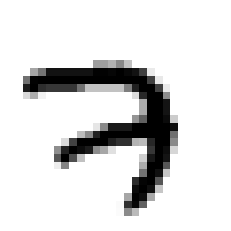

In [112]:
plt.imshow(X_train[0], cmap="binary")
plt.axis("off")
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9. Conveniently, the class IDs correspond to the digits represented in the images, so we don't need a class_names array:

In [110]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

In [113]:
X_train.shape

(55000, 28, 28)

In [114]:
X_valid.shape

(5000, 28, 28)

In [115]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

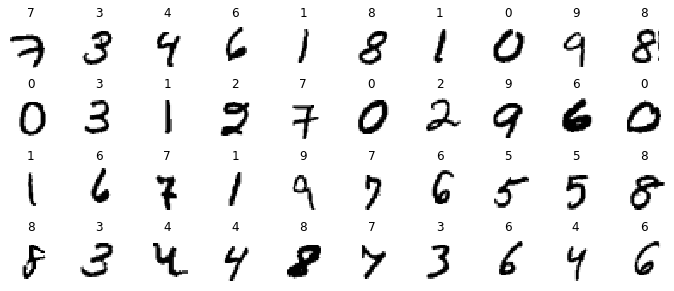

In [116]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis("off")
        plt.title(y_train[index], fontsize=12)
        
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

In [117]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [118]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [119]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), 
    keras.layers.Dense(300, activation="relu"), 
    keras.layers.Dense(100, activation="relu"), 
    keras.layers.Dense(10, activation="softmax")
])

We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration:

In [120]:
model.compile(loss="sparse_categorical_crossentropy", 
             optimizer=keras.optimizers.SGD(lr=1e-3), 
             metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

Now let's train the model for just 1 epoch:

In [121]:
history = model.fit(X_train, y_train, epochs=1, 
                   validation_data=(X_valid, y_valid), 
                   callbacks=[expon_lr])

1719/1719 [==============================] - 9s 5ms/step - loss: 2.8410 - accuracy: 0.4894 - val_loss: 2.3944 - val_accuracy: 0.1126


We can now plot the loss as a function of the learning rate:

Text(0, 0.5, 'Loss')

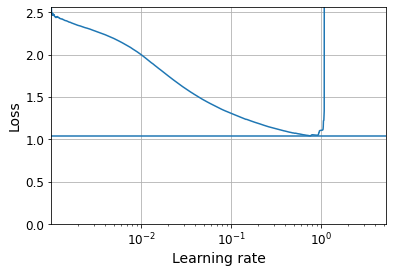

In [122]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale("log")
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

The loss starts shooting back up violently when the learning rate goes over 6e-1, so let's try using half of that, at 3e-1:

In [123]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [124]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [125]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=3e-1),
              metrics=["accuracy"])

In [126]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'.\\my_mnist_logs\\run_001'

In [127]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100, 
                   validation_data=(X_valid, y_valid), 
                   callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4200 - accuracy: 0.8678 - val_loss: 0.1022 - val_accuracy: 0.9696
Epoch 2/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0939 - accuracy: 0.9700 - val_loss: 0.0928 - val_accuracy: 0.9720
Epoch 3/100
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0672 - accuracy: 0.9779 - val_loss: 0.0817 - val_accuracy: 0.9768
Epoch 4/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0446 - accuracy: 0.9848 - val_loss: 0.0808 - val_accuracy: 0.9770
Epoch 5/100
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0370 - accuracy: 0.9876 - val_loss: 0.0911 - val_accuracy: 0.9746
Epoch 6/100
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0299 - accuracy: 0.9907 - val_loss: 0.0809 - val_accuracy: 0.9802
Epoch 7/100
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0242 - accuracy: 0.9926 - val_loss: 0.0710 - val_a

In [128]:
model = keras.models.load_model("my_mnist_model.h5") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0721 - accuracy: 0.9818


[0.07211431115865707, 0.9818000197410583]

We got over 98% accuracy. Finally, let's look at the learning curves using TensorBoard:

In [130]:
%tensorboard --logdir=./my_mnist_logs --port=6006

Reusing TensorBoard on port 6006 (pid 10472), started 0:07:43 ago. (Use '!kill 10472' to kill it.)